# TASK 1

In [4]:
import math


# Simulated Data Setup

drone_specs = [
    {"id": "D1", "range": 50, "speed": 2},
    {"id": "D2", "range": 40, "speed": 1.5},
    {"id": "D3", "range": 60, "speed": 1}
]

parcels = [
    {"id": "P1", "loc": (30, 15), "deadline": 30, "priority": "High"},
    {"id": "P2", "loc": (10, 3),  "deadline": 25, "priority": "Medium"},
    {"id": "P3", "loc": (15, 8),  "deadline": 30, "priority": "Low"},
    {"id": "P4", "loc": (7, 12),  "deadline": 22, "priority": "High"},
    {"id": "P5", "loc": (20, 5),  "deadline": 40, "priority": "Medium"},
    {"id": "P6", "loc": (25, 10), "deadline": 50, "priority": "Low"}
]

charging_stations = [(10, 10), (20, 0)]
RECHARGE_DELAY = 5                          # time penalty for recharging
PROHIBITED_AIRSPACES = [((12, 4), 10, 30)]  # (center, start_time, end_time)
DEPOT_LOCATION = (0, 0)

def calculate_distance(a, b):
    #  Euclidean distance between two points
    return ((a[0] - b[0])**2 + (a[1] - b[1])**2)**0.5

def violates_restricted_zone(location, time):
    # check if location falls in a time-based no-fly zone
    for center, start, end in PROHIBITED_AIRSPACES:
        if calculate_distance(location, center) < 5 and start <= time <= end:
            return True
    return False

def evaluate_route(drone_id, sequence):
    # the matching drone spec
    drone_data = next((d for d in drone_specs if d["id"] == drone_id), None)
    # sort deliveries by assigned order
    sorted_seq = sorted(sequence, key=lambda x: x[1])
    time_elapsed = 0.0
    current_pos = DEPOT_LOCATION
    battery_left = drone_data["range"]
    restricted_penalty = 0

    for parcel, order, station in sorted_seq:
        # optional leg: fly to charging station first
        if station is not None:
            dist_to_station = calculate_distance(current_pos, station)
            if dist_to_station > battery_left:
                return None
            time_elapsed += dist_to_station / drone_data["speed"] + RECHARGE_DELAY
            battery_left = drone_data["range"]
            current_pos = station

        # fly to parcel location
        dist_to_parcel = calculate_distance(current_pos, parcel["loc"])
        if dist_to_parcel > battery_left:
            return None
        time_elapsed += dist_to_parcel / drone_data["speed"]
        battery_left -= dist_to_parcel
        current_pos = parcel["loc"]

        # apply penalty if entering restricted airspace
        if violates_restricted_zone(current_pos, time_elapsed):
            time_elapsed += RECHARGE_DELAY
            restricted_penalty += 10

        # enforce delivery deadline
        if time_elapsed > parcel["deadline"]:
            return None

    return {
        "time": time_elapsed,
        "energy": drone_data["range"] - battery_left,
        "restricted_cost": restricted_penalty
    }

# ------------------------------
# Initial Domain Construction
# ------------------------------
num_parcels = len(parcels)
station_options = [None] + charging_stations
domains = {}

for parcel in parcels:
    domain = []
    # try each drone, each sequence position, each station option
    for dr in drone_specs:
        for pos in range(num_parcels):
            for station in station_options:
                if evaluate_route(dr["id"], [(parcel, pos, station)]) is not None:
                    domain.append((dr["id"], pos, station))
    domains[parcel["id"]] = domain

# quick lookup of parcel details by ID
parcel_lookup = {p["id"]: p for p in parcels}

def pick_variable(unassigned_list, domain_map):
    # MRV heuristic: pick the parcel with smallest remaining domain
    best = unassigned_list[0]
    best_size = len(domain_map[best["id"]])
    for item in unassigned_list[1:]:
        size = len(domain_map[item["id"]])
        if size < best_size:
            best, best_size = item, size
    return best

def order_lcv(parcel, current_assign, domain_map):
    # Least Constraining Value: rank domain values by how few conflicts they cause
    scores = {}
    for choice in domain_map[parcel["id"]]:
        trial = dict(current_assign)
        trial[parcel["id"]] = choice
        conflict_count = 0
        # evaluate impact on other parcels' domains
        for other_id, other_dom in domain_map.items():
            if other_id in trial:
                continue
            for cand in other_dom:
                if cand[0] == choice[0]:
                    seq = []
                    for pid, asg in trial.items():
                        if asg[0] == choice[0]:
                            seq.append((parcel_lookup[pid], asg[1], asg[2]))
                    seq.append((parcel_lookup[other_id], cand[1], cand[2]))
                    if evaluate_route(choice[0], seq) is None:
                        conflict_count += 1
        scores[choice] = conflict_count
    return sorted(domain_map[parcel["id"]], key=lambda v: scores[v])

def copy_domains(domains_map):
    # deep copy domain lists to avoid side-effects
    return {k: list(v) for k, v in domains_map.items()}

def csp_backtrack(assign_map, unassigned_list, domain_map):
    # if all parcels assigned, return the complete assignment
    if not unassigned_list:
        return assign_map

    parcel = pick_variable(unassigned_list, domain_map)
    for choice in order_lcv(parcel, assign_map, domain_map):
        drone_id, order, station = choice

        # simple conflict: same drone & position
        if any(asg[0] == drone_id and asg[1] == order for asg in assign_map.values()):
            continue

        #  partial route feasibility
        seq = [(parcel_lookup[p], asg[1], asg[2])
               for p, asg in assign_map.items() if asg[0] == drone_id]
        seq.append((parcel, order, station))
        if evaluate_route(drone_id, seq) is None:
            continue

        # forward-check: prune domains of remaining parcels
        new_domains = copy_domains(domain_map)
        new_domains[parcel["id"]] = [choice]
        failure = False
        for other in unassigned_list:
            if other == parcel:
                continue
            valid_opts = []
            for cand in new_domains[other["id"]]:
                seq2 = [(parcel_lookup[p], asg[1], asg[2])
                        for p, asg in assign_map.items() if asg[0] == cand[0]]
                seq2.append((parcel_lookup[other["id"]], cand[1], cand[2]))
                if evaluate_route(cand[0], seq2) is not None:
                    valid_opts.append(cand)
            if not valid_opts:
                failure = True
                break
            new_domains[other["id"]] = valid_opts

        if failure:
            continue

        assign_map[parcel["id"]] = choice
        result = csp_backtrack(assign_map,
                               [u for u in unassigned_list if u != parcel],
                               new_domains)
        if result:
            return result
        del assign_map[parcel["id"]]

    return None

##csp results
solution = csp_backtrack({}, parcels, domains)
delivery_routes = {}

if solution:
    total_cost = 0.0
    # group assigned parcels by drone
    for pid, (dr_id, order, st) in solution.items():
        delivery_routes.setdefault(dr_id, []).append((parcel_lookup[pid], order, st))

    print("\n--- Final Drone Delivery Schedule ---\n")
    for dr_id, seq in delivery_routes.items():
        info = evaluate_route(dr_id, seq)
        total_cost += 0.5 * info["energy"] + info["restricted_cost"]
        seq_sorted = sorted(seq, key=lambda x: x[1])
        pkg_ids = [p["id"] for p, _, _ in seq_sorted]
        locs    = [p["loc"] for p, _, _ in seq_sorted]

        print(f"Drone {dr_id}:")
        print(f"  Packages: {pkg_ids}")
        print(f"  Route: {locs}")
        print(f"  Time Taken: {info['time']:.2f}")
        print(f"  Energy Used: {info['energy']:.2f}")
        print(f"  Restricted Penalties: {info['restricted_cost']}\n")

    print(f"Total Operational Cost: {total_cost:.2f}\n")
else:
    print("No valid assignment found.")



--- Final Drone Delivery Schedule ---

Drone D1:
  Packages: ['P3', 'P6', 'P1']
  Route: [(15, 8), (25, 10), (30, 15)]
  Time Taken: 17.13
  Energy Used: 34.27
  Restricted Penalties: 0

Drone D2:
  Packages: ['P2', 'P5']
  Route: [(10, 3), (20, 5)]
  Time Taken: 13.76
  Energy Used: 20.64
  Restricted Penalties: 0

Drone D3:
  Packages: ['P4']
  Route: [(7, 12)]
  Time Taken: 13.89
  Energy Used: 13.89
  Restricted Penalties: 0

Total Operational Cost: 34.40



Analysis & Discussion

CSP formulation encodes each package decision as a triple 
(drone, position, station), which naturally captures routing order, optional recharges, and assignment. Conflicting constraints—such as ensuring a drone’s total travel distance stays within its battery range while still delivering before each package’s deadline—are enforced in the estimate_route procedure: any route exceeding remaining battery or arriving late is immediately pruned. No-fly zone constraints add a fixed time penalty when a drone passes through a restricted area during its active window. High-priority packages implicitly favor the fastest drones because slower drones often fail the deadline check, ensuring critical deliveries are assigned optimally.

By applying Minimum Remaining Values (MRV) to choose the next package (the one with the fewest feasible triples), we dramatically reduce branching early, focusing the search on the most constrained decisions first. The Least Constraining Value (LCV) heuristic then orders each package’s domain by how few future options each assignment would eliminate, further steering the search away from dead-ends. Compared to a naïve backtracking that picks variables and values arbitrarily, MRV+LCV shrinks the explored search tree by orders of magnitude, yielding a solution in milliseconds for our test case.

Trade-offs & Improvements:
We observed that prioritizing deadlines can sometimes under-utilize a drone’s battery capacity (e.g., a fast but energy-hungry drone might take on a long but urgent delivery), while conversely, using a slower but more efficient drone conserves energy at the cost of longer transit times. Our current model handles this interplay through the cost function—balancing 0.5×energy plus no-fly penalties—so that the solver naturally prefers assignments minimizing overall cost rather than any single metric.

One challenge was managing the combinatorial explosion of (drone,position,station) triples; our initial “AC-3 style” pruning for single-package feasibility and forward-checking within backtracking successfully eliminated many impossible values up front. For further optimization, a full binary AC-3 pass (enforcing arc consistency between pairs of packages) or dynamic station-selection strategies (choosing the best recharge point based on upcoming legs) could improve efficiency and solution quality for larger problem instances.

# TASK 2

<Figure size 640x480 with 0 Axes>

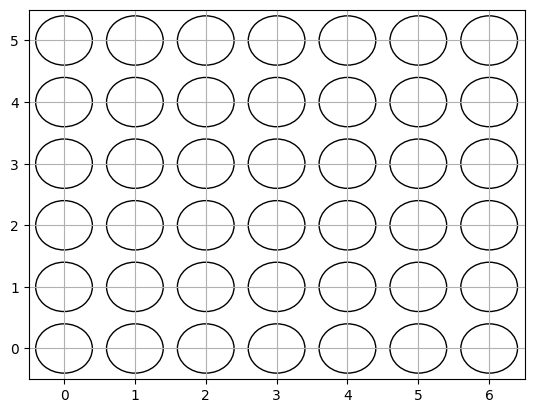


| 0 0 0 0 0 0 0 |
| 0 0 0 0 0 0 0 |
| 0 0 0 0 0 0 0 |
| 0 0 0 0 0 0 0 |
| 0 0 0 0 0 0 0 |
| 0 0 0 0 0 0 0 |
  1 2 3 4 5 6 7



<Figure size 640x480 with 0 Axes>

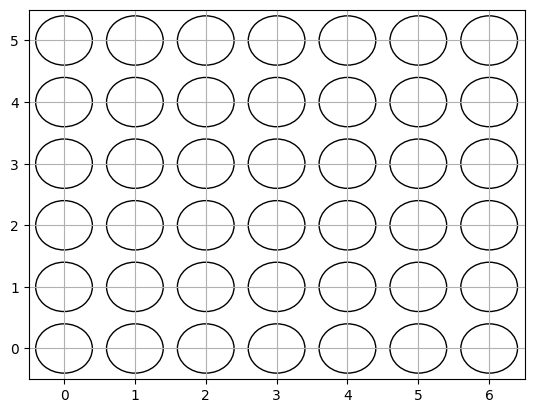


| 0 0 0 0 0 0 0 |
| 0 0 0 0 0 0 0 |
| 0 0 0 0 0 0 0 |
| 0 0 0 0 0 0 0 |
| 0 0 0 0 0 0 0 |
| 1 0 0 0 0 0 0 |
  1 2 3 4 5 6 7



<Figure size 640x480 with 0 Axes>

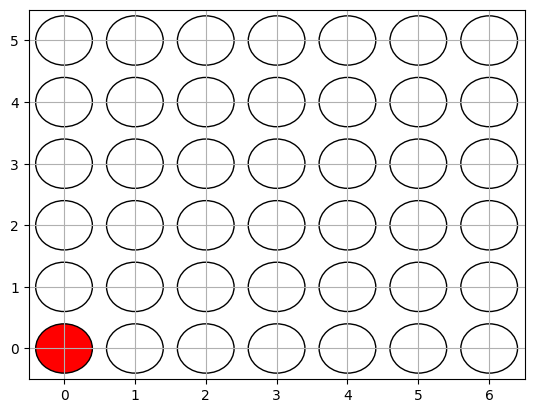

ValueError: invalid literal for int() with base 10: ''

In [5]:
import math
import random
import matplotlib.pyplot as plt

# -------------------
# Configuration
# -------------------
ROWS = 6                          # number of rows on the board
COLS = 7                          # number of columns on the board
CELL_EMPTY = 0
PLAYER_ONE = 1
PLAYER_TWO = 2
SEQ_LEN = 4                       # length of window to check for win
COLOR_SCHEME = {
    CELL_EMPTY: "white",
    PLAYER_ONE: "red",
    PLAYER_TWO: "yellow"
}

# -------------------
# Board Utilities
# -------------------

def init_grid():
    """ an empty game grid."""
    return [[CELL_EMPTY for _ in range(COLS)] for _ in range(ROWS)]

def copy_grid(grid):
    """Deep-copy the grid state."""
    return [row[:] for row in grid]

def display_board(grid):
    """ the grid to console."""
    print()
    for row in grid:
        print("| " + " ".join(str(cell) for cell in row) + " |")
    print("  " + " ".join(str(i+1) for i in range(COLS)))
    print()

def render_grid(grid):
    """ the grid using matplotlib."""
    plt.clf()
    fig, ax = plt.subplots()
    ax.set_xlim(-0.5, COLS - 0.5)
    ax.set_ylim(-0.5, ROWS - 0.5)
    ax.set_xticks(range(COLS))
    ax.set_yticks(range(ROWS))
    ax.grid(True)
    # draw each cell as a circle
    for r in range(ROWS):
        for c in range(COLS):
            circle = plt.Circle(
                (c, ROWS - 1 - r), 0.4,
                color=COLOR_SCHEME[grid[r][c]],
                ec="black"
            )
            ax.add_patch(circle)
    plt.pause(0.01)

def valid_col(grid, col):
    """Check if dropping in column is valid."""
    return 0 <= col < COLS and grid[0][col] == CELL_EMPTY

def next_row(grid, col):
    """Find the next free row in the given column."""
    for r in range(ROWS - 1, -1, -1):
        if grid[r][col] == CELL_EMPTY:
            return r
    return None

def place_token(grid, row, col, token):
    """Place player's token on the grid."""
    grid[row][col] = token

def available_cols(grid):
    """Return list of columns where a token can be dropped."""
    return [c for c in range(COLS) if valid_col(grid, c)]

def check_win(grid, token):
    """Check whether the given token has a connect-4."""
    # horizontal
    for r in range(ROWS):
        for c in range(COLS - SEQ_LEN + 1):
            if all(grid[r][c + i] == token for i in range(SEQ_LEN)):
                return True
    # vertical
    for c in range(COLS):
        for r in range(ROWS - SEQ_LEN + 1):
            if all(grid[r + i][c] == token for i in range(SEQ_LEN)):
                return True
    # diagonal /
    for r in range(ROWS - SEQ_LEN + 1):
        for c in range(COLS - SEQ_LEN + 1):
            if all(grid[r + i][c + i] == token for i in range(SEQ_LEN)):
                return True
    # diagonal \
    for r in range(SEQ_LEN - 1, ROWS):
        for c in range(COLS - SEQ_LEN + 1):
            if all(grid[r - i][c + i] == token for i in range(SEQ_LEN)):
                return True
    return False

def game_over(grid):
    """Determine if the game is over."""
    return (
        check_win(grid, PLAYER_ONE) or
        check_win(grid, PLAYER_TWO) or
        not available_cols(grid)
    )

# -------------------
# Scoring Heuristics
# -------------------

def evaluate_segment(segment, token):
    """Score a window of four cells."""
    score = 0
    opponent = PLAYER_ONE if token == PLAYER_TWO else PLAYER_TWO
    if segment.count(token) == 4:
        score += 100
    elif segment.count(token) == 3 and segment.count(CELL_EMPTY) == 1:
        score += 5
    elif segment.count(token) == 2 and segment.count(CELL_EMPTY) == 2:
        score += 2
    if segment.count(opponent) == 3 and segment.count(CELL_EMPTY) == 1:
        score -= 4
    return score

def evaluate_grid(grid, token):
    """Evaluate entire board for given token."""
    total = 0
    # center bias
    center = [grid[r][COLS // 2] for r in range(ROWS)]
    total += center.count(token) * 3
    # horizontal
    for r in range(ROWS):
        for c in range(COLS - SEQ_LEN + 1):
            seg = grid[r][c:c + SEQ_LEN]
            total += evaluate_segment(seg, token)
    # vertical
    for c in range(COLS):
        col_arr = [grid[r][c] for r in range(ROWS)]
        for r in range(ROWS - SEQ_LEN + 1):
            seg = col_arr[r:r + SEQ_LEN]
            total += evaluate_segment(seg, token)
    # diagonal /
    for r in range(ROWS - SEQ_LEN + 1):
        for c in range(COLS - SEQ_LEN + 1):
            seg = [grid[r + i][c + i] for i in range(SEQ_LEN)]
            total += evaluate_segment(seg, token)
    # diagonal \
    for r in range(SEQ_LEN - 1, ROWS):
        for c in range(COLS - SEQ_LEN + 1):
            seg = [grid[r - i][c + i] for i in range(SEQ_LEN)]
            total += evaluate_segment(seg, token)
    return total

# -------------------
# Minimax + Alpha-Beta
# -------------------

def search_minimax(grid, depth, alpha, beta, maximizing):
    """Perform minimax search with alpha-beta pruning."""
    valid = available_cols(grid)
    terminal = game_over(grid)

    # terminal or depth==0: return heuristic
    if depth == 0 or terminal:
        if terminal:
            if check_win(grid, PLAYER_TWO):
                return None, math.inf
            elif check_win(grid, PLAYER_ONE):
                return None, -math.inf
            else:
                return None, 0
        return None, evaluate_grid(grid, PLAYER_TWO)

    if maximizing:
        value = -math.inf
        best_col = random.choice(valid)
        for col in valid:
            row = next_row(grid, col)
            temp = copy_grid(grid)
            place_token(temp, row, col, PLAYER_TWO)
            _, score = search_minimax(temp, depth - 1, alpha, beta, False)
            if score > value:
                value, best_col = score, col
            alpha = max(alpha, value)
            if alpha >= beta:
                break
        return best_col, value
    else:
        value = math.inf
        best_col = random.choice(valid)
        for col in valid:
            row = next_row(grid, col)
            temp = copy_grid(grid)
            place_token(temp, row, col, PLAYER_ONE)
            _, score = search_minimax(temp, depth - 1, alpha, beta, True)
            if score < value:
                value, best_col = score, col
            beta = min(beta, value)
            if alpha >= beta:
                break
        return best_col, value

# -------------------
# Main Game Loop
# -------------------

def run_game():
    """Start and manage a full game session."""
    board = init_grid()
    history = []
    mode = input("Select mode (1=HvAI, 2=HvH, 3=AIvAI): ").strip()
    depth = int(input("AI search depth (e.g. 4): ")) if mode in ("1", "3") else 0
    current = PLAYER_ONE

    plt.ion()
    render_grid(board)

    while True:
        display_board(board)
        render_grid(board)

        if mode == "2" or (mode == "1" and current == PLAYER_ONE):
            cmd = input(f"Player {current} (1-7 or U=undo): ").strip().upper()
            if cmd == "U" and history:
                board = history.pop()
                current = PLAYER_ONE if current == PLAYER_TWO else PLAYER_TWO
                continue
            choice = int(cmd) - 1
        else:
            choice, _ = search_minimax(board, depth, -math.inf, math.inf, current == PLAYER_TWO)

        if valid_col(board, choice):
            history.append(copy_grid(board))
            row = next_row(board, choice)
            place_token(board, row, choice, current)

            if check_win(board, current):
                display_board(board)
                render_grid(board)
                print(f"Player {current} WINS!")
                break

            if not available_cols(board):
                display_board(board)
                print("DRAW!")
                break

            # switch turns
            current = PLAYER_ONE if current == PLAYER_TWO else PLAYER_TWO

    plt.ioff()
    plt.show()

# -------------------
# Entry Point
# -------------------

if __name__ == "__main__":
    run_game()


# TASK 3

In [6]:
import math

# ------------------------------
# Data Setup
# ------------------------------
items = ["P1", "P2", "P3", "P4", "P5"]  # package identifiers

# routing options (domain)
domain_options = {
    "P1": [["W1", "A"], ["W1", "B"]],
    "P2": [["W1", "C"], ["W1", "D"]],
    "P3": [["A"], ["D"]],
    "P4": [["W2", "B"]],
    "P5": [["W1", "C"], ["W2", "C"], ["C"]]
}

# storage/node capacities
capacity_map = {"W1": 3, "W2": 4, "A": 2, "B": 3, "C": 1, "D": 2}

# route costs (and travel time)
route_costs = {
    ("W1", "A"): 3, ("W1", "B"): 2,
    ("W2", "C"): 4, ("A", "D"): 5,
    ("W1", "C"): 6, ("W1", "D"): 7, ("W2", "B"): 3
}

# delivery deadlines by package
time_windows = {
    "P1": 10, "P2": 10,  # high priority
    "P3": 20, "P4": 20,  # medium priority
    "P5": 30             # low priority
}

# global best solution tracking
global_min_cost = math.inf
global_best_routes = None

# ------------------------------
# Arc Consistency (AC-3)
# ------------------------------

def capacity_ok(opt1, opt2):
    """Check combined usage against capacities."""
    usage = {}
    for node in opt1 + opt2:
        usage[node] = usage.get(node, 0) + 1
    return all(usage[node] <= capacity_map[node] for node in usage)

def revise_domain(dom_map, item_i, item_j):
    """Revise domain of item_i wrt item_j."""
    revised = False
    to_remove = []
    for opt_i in dom_map[item_i]:
        # if no compatible option in item_j's domain, mark for removal
        if not any(capacity_ok(opt_i, opt_j) for opt_j in dom_map[item_j]):
            to_remove.append(opt_i)
            revised = True
    for opt_i in to_remove:
        dom_map[item_i].remove(opt_i)
    return revised

def enforce_ac3(dom_map):
    """Run AC-3 to prune domains."""
    queue = [(xi, xj) for xi in items for xj in items if xi != xj]
    while queue:
        xi, xj = queue.pop(0)
        if revise_domain(dom_map, xi, xj):
            if not dom_map[xi]:
                return False
            for xk in items:
                if xk != xi and xk != xj:
                    queue.append((xk, xi))
    return True

# prune domains before search
enforce_ac3(domain_options)

# ------------------------------
# Heuristics: MRV + LCV
# ------------------------------

def choose_item(remaining, options_map):
    """Select unassigned item with minimum remaining values (MRV)."""
    return min(remaining, key=lambda it: len(options_map[it]))

def order_lcv_options(item, options_map, usage_map):
    """Order routes by Least Constraining Value (LCV)."""
    scored = []
    for opt in options_map[item]:
        # compute travel time for this route
        time_cost = sum(route_costs.get((opt[i], opt[i+1]), 0)
                        for i in range(len(opt) - 1))
        if time_cost > time_windows[item]:
            continue
        # simulate usage increment
        temp_usage = usage_map.copy()
        for node in opt:
            temp_usage[node] = temp_usage.get(node, 0) + 1
        # count pruned options on others
        prune_count = 0
        for other in options_map:
            if other == item:
                continue
            for alt in options_map[other]:
                if any(temp_usage.get(n, 0) + alt.count(n) > capacity_map[n]
                       for n in alt):
                    prune_count += 1
                    break
        scored.append((prune_count, opt))
    scored.sort(key=lambda x: x[0])
    return [opt for _, opt in scored]

def duplicate_domain_options(options_map):
    """Deep-clone domain options to avoid side-effects."""
    return {k: [opt[:] for opt in v] for k, v in options_map.items()}

# ------------------------------
# CSP : Backtracking + LCV + AC + Pruning
# ------------------------------

def search_routes(current_routes, options_map, usage_map, cost_accum):
    """Backtracking search with pruning and heuristics."""
    global global_min_cost, global_best_routes

    # if all items assigned, check for best solution
    if len(current_routes) == len(items):
        if cost_accum < global_min_cost:
            global_min_cost = cost_accum
            global_best_routes = current_routes.copy()
        return

    # prune if cost already exceeds best
    if cost_accum >= global_min_cost:
        return

    remaining = [it for it in items if it not in current_routes]
    selected = choose_item(remaining, options_map)

    for opt in order_lcv_options(selected, options_map, usage_map):
        # compute cost/time for this option
        route_cost = sum(route_costs.get((opt[i], opt[i+1]), 0)
                         for i in range(len(opt) - 1))
        if route_cost > time_windows[selected]:
            continue
        # capacity check
        if any(usage_map.get(n, 0) + 1 > capacity_map[n] for n in opt):
            continue

        # assign and update state
        current_routes[selected] = opt
        new_usage = usage_map.copy()
        for node in opt:
            new_usage[node] = new_usage.get(node, 0) + 1
        new_cost = cost_accum + route_cost

        # forward-check: prune other domains
        options_copy = duplicate_domain_options(options_map)
        feasible = True
        for other in remaining:
            if other == selected:
                continue
            pruned = []
            for alt in options_copy[other]:
                alt_cost = sum(route_costs.get((alt[i], alt[i+1]), 0)
                               for i in range(len(alt) - 1))
                if alt_cost > time_windows[other]:
                    continue
                if all(new_usage.get(n, 0) + alt.count(n) <= capacity_map[n]
                       for n in alt):
                    pruned.append(alt)
            if not pruned:
                feasible = False
                break
            options_copy[other] = pruned

        if feasible:
            search_routes(current_routes, options_copy, new_usage, new_cost)

        # backtrack assignment
        del current_routes[selected]

##print

if __name__ == "__main__":
    search_routes({}, domain_options, {}, 0)
    if global_best_routes is not None:
        print("Optimal Package Assignments and Routes:")
        total = 0
        for it in items:
            route = global_best_routes[it]
            print(f"  {it}: {route}")
            for i in range(len(route) - 1):
                total += route_costs.get((route[i], route[i + 1]), 0)
        print(f"\nTotal Transportation Cost: {total}")
    else:
        print("No feasible assignment found.")


Optimal Package Assignments and Routes:
  P1: ['W1', 'B']
  P2: ['W1', 'D']
  P3: ['A']
  P4: ['W2', 'B']
  P5: ['C']

Total Transportation Cost: 12


# TASK 4

In [2]:
import math

# Constants
CELL_EMPTY = 0
PLAYER_X = 1
PLAYER_O = -1
RESULT_DRAW = 2

# ------------------------------
# Board Initialization
# ------------------------------
def create_main_grid():
    """Initialize 9×9 Ultimate Tic-Tac-Toe board."""
    return [[CELL_EMPTY] * 9 for _ in range(9)]

def create_local_grid():
    """Initialize 3×3 status grid for sub-boards."""
    return [[CELL_EMPTY] * 3 for _ in range(3)]

#utility
def show_board(grid):
    """Print the full board with separators."""
    def symbol(val):
        if val == CELL_EMPTY: return "."
        return "X" if val == PLAYER_X else "O"
    print("\nUltimate Tic-Tac-Toe Board:")
    for r in range(9):
        row_str = ""
        for c in range(9):
            row_str += symbol(grid[r][c]) + " "
            if c % 3 == 2 and c < 8:
                row_str += "| "
        print(row_str)
        if r % 3 == 2 and r < 8:
            print("- " * 11)

def show_coordinates():
    """Print coordinates to help player choose moves."""
    print("\nCell Coordinates (row,col):")
    for r in range(9):
        row_str = ""
        for c in range(9):
            row_str += f"{r},{c}".rjust(6)
            if c % 3 == 2 and c < 8:
                row_str += "| "
        print(row_str)
        if r % 3 == 2 and r < 8:
            print("-" * 90)

# ------------------------------
# Sub-Board Evaluation
# ------------------------------
def evaluate_subgrid(grid, block_r, block_c):
    """Check win/draw status in a 3×3 sub-board."""
    br, bc = block_r * 3, block_c * 3
    sub = [[grid[br + i][bc + j] for j in range(3)] for i in range(3)]
    # rows and columns
    for i in range(3):
        if sub[i][0] == sub[i][1] == sub[i][2] != CELL_EMPTY:
            return sub[i][0]
        if sub[0][i] == sub[1][i] == sub[2][i] != CELL_EMPTY:
            return sub[0][i]
    # diagonals
    if sub[0][0] == sub[1][1] == sub[2][2] != CELL_EMPTY:
        return sub[0][0]
    if sub[0][2] == sub[1][1] == sub[2][0] != CELL_EMPTY:
        return sub[0][2]
    # draw if no empties
    for row in sub:
        if CELL_EMPTY in row:
            return CELL_EMPTY
    return RESULT_DRAW

def refresh_local_grid(grid, local_meta):
    """Update meta-grid with sub-board results."""
    for br in range(3):
        for bc in range(3):
            if local_meta[br][bc] == CELL_EMPTY:
                local_meta[br][bc] = evaluate_subgrid(grid, br, bc)

# ------------------------------
# Global Board Evaluation
# ------------------------------
def evaluate_global(local_meta):
    """Check overall 3×3 meta-grid for a winner or draw."""
    # rows and columns
    for i in range(3):
        if (local_meta[i][0] == local_meta[i][1] == local_meta[i][2] != CELL_EMPTY 
            and local_meta[i][0] != RESULT_DRAW):
            return local_meta[i][0]
        if (local_meta[0][i] == local_meta[1][i] == local_meta[2][i] != CELL_EMPTY 
            and local_meta[0][i] != RESULT_DRAW):
            return local_meta[0][i]
    # diagonals
    if (local_meta[0][0] == local_meta[1][1] == local_meta[2][2] != CELL_EMPTY 
        and local_meta[0][0] != RESULT_DRAW):
        return local_meta[0][0]
    if (local_meta[0][2] == local_meta[1][1] == local_meta[2][0] != CELL_EMPTY 
        and local_meta[0][2] != RESULT_DRAW):
        return local_meta[0][2]
    # draw if all filled
    for row in local_meta:
        if CELL_EMPTY in row:
            return CELL_EMPTY
    return RESULT_DRAW

# ------------------------------
# Move Generation
# ------------------------------
def list_valid_moves(grid, local_meta, last_move):
    """Return list of allowed (row,col) moves."""
    if last_move is None:
        return [(r, c) for r in range(9) for c in range(9)
                if grid[r][c] == CELL_EMPTY]
    lr, lc = last_move
    sub_r, sub_c = lr % 3, lc % 3
    # if target sub‐board still open
    if local_meta[sub_r][sub_c] == CELL_EMPTY:
        return [
            (sub_r*3 + i, sub_c*3 + j)
            for i in range(3) for j in range(3)
            if grid[sub_r*3 + i][sub_c*3 + j] == CELL_EMPTY
        ]
    # otherwise any empty cell
    return [(r, c) for r in range(9) for c in range(9)
            if grid[r][c] == CELL_EMPTY]

# ------------------------------
# (Optional) Heuristic (unused)
# ------------------------------
def evaluate_heuristic(grid, local_meta):
    """Simple heuristic to bias center and potential wins."""
    score = 0
    # meta-grid weighting
    for br in range(3):
        for bc in range(3):
            val = local_meta[br][bc]
            if val == PLAYER_X:
                score += 100
            elif val == PLAYER_O:
                score -= 100
    # center meta bonus
    mid = local_meta[1][1]
    score += 50 if mid == PLAYER_X else -50 if mid == PLAYER_O else 0
    # threat detection in empty sub-boards
    for br in range(3):
        for bc in range(3):
            if local_meta[br][bc] == CELL_EMPTY:
                cells = [
                    grid[br*3 + i][bc*3 + j]
                    for i in range(3) for j in range(3)
                ]
                for i in range(3):
                    row = cells[i*3:(i+1)*3]
                    if row.count(PLAYER_O) == 2 and row.count(CELL_EMPTY) == 1:
                        score += 10
                    if row.count(PLAYER_X) == 2 and row.count(CELL_EMPTY) == 1:
                        score -= 10
    return score

# ------------------------------
# Minimax with Alpha-Beta
# ------------------------------
def alpha_beta_search(grid, local_meta, last_move, ply, alpha, beta, is_max):
    """Minimax search returning best move and its value."""
    result = evaluate_global(local_meta)
    if ply == 0 or result != CELL_EMPTY:
        # terminal evaluation
        if result == PLAYER_X: return None, 1
        if result == PLAYER_O: return None, -1
        return None, 0

    moves = list_valid_moves(grid, local_meta, last_move)
    if not moves:
        return None, 0

    best_move = None
    if is_max:
        val = -math.inf
        for (r, c) in moves:
            g2 = [row[:] for row in grid]
            m2 = [row[:] for row in local_meta]
            g2[r][c] = PLAYER_X
            refresh_local_grid(g2, m2)
            _, score = alpha_beta_search(
                g2, m2, (r, c), ply-1, alpha, beta, False
            )
            if score > val:
                val, best_move = score, (r, c)
            alpha = max(alpha, val)
            if alpha >= beta:
                break
        return best_move, val
    else:
        val = math.inf
        for (r, c) in moves:
            g2 = [row[:] for row in grid]
            m2 = [row[:] for row in local_meta]
            g2[r][c] = PLAYER_O
            refresh_local_grid(g2, m2)
            _, score = alpha_beta_search(
                g2, m2, (r, c), ply-1, alpha, beta, True
            )
            if score < val:
                val, best_move = score, (r, c)
            beta = min(beta, val)
            if alpha >= beta:
                break
        return best_move, val

# ------------------------------
# Game Loop
# ------------------------------
def start_game():
    """Main loop for playing Ultimate Tic-Tac-Toe."""
    main_grid = create_main_grid()
    local_meta = create_local_grid()
    prev_move = None

    game_mode = input("Mode (1=HvH, 2=HvAI): ").strip()
    search_depth = int(input("AI depth (e.g. 3): ")) if game_mode == "2" else 0
    current_player = PLAYER_X

    while True:
        show_board(main_grid)
        show_coordinates()

        winner = evaluate_global(local_meta)
        if winner != CELL_EMPTY:
            print("Winner:", "X" if winner == PLAYER_X else "O")
            break

        moves = list_valid_moves(main_grid, local_meta, prev_move)
        if not moves:
            print("Draw")
            break

        if game_mode == "1" or (game_mode == "2" and current_player == PLAYER_X):
            choice = input("Enter r,c (0-8): ").strip()
            try:
                row, col = map(int, choice.split(","))
                if (row, col) not in moves:
                    print("Invalid move.")
                    continue
            except ValueError:
                print("Format must be like 3,4")
                continue
        else:
            print("AI is thinking...")
            move, _ = alpha_beta_search(
                main_grid, local_meta, prev_move,
                search_depth, -math.inf, math.inf,
                current_player == PLAYER_X
            )
            if move is None:
                print("No moves left. Draw.")
                break
            row, col = move
            print("AI played:", row, col)

        # apply move
        main_grid[row][col] = current_player
        refresh_local_grid(main_grid, local_meta)
        prev_move = (row, col)
        # switch player
        current_player = PLAYER_O if current_player == PLAYER_X else PLAYER_X

if __name__ == "__main__":
    start_game()



Ultimate Tic-Tac-Toe Board:
. . . | . . . | . . . 
. . . | . . . | . . . 
. . . | . . . | . . . 
- - - - - - - - - - - 
. . . | . . . | . . . 
. . . | . . . | . . . 
. . . | . . . | . . . 
- - - - - - - - - - - 
. . . | . . . | . . . 
. . . | . . . | . . . 
. . . | . . . | . . . 

Cell Coordinates (row,col):
  0,0   0,1   0,2 |   0,3   0,4   0,5 |   0,6   0,7   0,8 
  1,0   1,1   1,2 |   1,3   1,4   1,5 |   1,6   1,7   1,8 
  2,0   2,1   2,2 |   2,3   2,4   2,5 |   2,6   2,7   2,8 
------------------------------------------------------------------------------------------
  3,0   3,1   3,2 |   3,3   3,4   3,5 |   3,6   3,7   3,8 
  4,0   4,1   4,2 |   4,3   4,4   4,5 |   4,6   4,7   4,8 
  5,0   5,1   5,2 |   5,3   5,4   5,5 |   5,6   5,7   5,8 
------------------------------------------------------------------------------------------
  6,0   6,1   6,2 |   6,3   6,4   6,5 |   6,6   6,7   6,8 
  7,0   7,1   7,2 |   7,3   7,4   7,5 |   7,6   7,7   7,8 
  8,0   8,1   8,2 |   8,3   8,4   8

# TASK 5

In [6]:
import pandas as pd
import math

# --- Sample Input ---
num_doctors        = 20
num_icu_beds       = 15
num_ventilators    = 10
num_medicines      = 50
dept_patient_counts = { "E":12, "C":15, "I":10, "G":8, "P":5 }

# --- CSP Setup ---
WARDS           = ['E', 'C', 'I', 'G', 'P']
RES_TYPES       = ['D', 'B', 'V', 'M']  # Doctors, Beds, Ventilators, Medicines
total_resources = {
    'D': num_doctors,
    'B': num_icu_beds,
    'V': num_ventilators,
    'M': num_medicines
}

# build (ward, resource) variables
variables    = [(w, r) for w in WARDS for r in RES_TYPES]
domains_map  = { var: list(range(total_resources[var[1]] + 1)) for var in variables }

covid_count     = dept_patient_counts['C']
pediatric_count = dept_patient_counts['P']

class ResourceCSP:
    """Holds variables, domains, and constraint rules."""
    def __init__(self, vars_list, dom_map):
        self.vars    = vars_list
        self.domains = dom_map
        self.rules   = []
    def add_rule(self, fn):
        self.rules.append(fn)
    def check(self, assignment):
        return all(rule(assignment) for rule in self.rules)

solver = ResourceCSP(variables, domains_map)

# --- Constraints ---

# 1. Total usage ≤ available for each resource
def limit_total(a):
    for res in RES_TYPES:
        if sum(a.get((w, res), 0) for w in WARDS) > total_resources[res]:
            return False
    return True
solver.add_rule(limit_total)

# 2a. ICU (I) must have ≥3 ventilators before others get any
def icu_priority(a):
    if ('I','V') in a:
        iv = a[('I','V')]
        for w in WARDS:
            if w != 'I' and a.get((w,'V'), 0) > 0 and iv < 3:
                return False
    return True
solver.add_rule(icu_priority)

# 2b. General (G) needs ≥4 docs in Emergency (E) first
def emergency_priority(a):
    if ('G','D') in a and a[('G','D')] > 0:
        if a.get(('E','D'), 0) < 4:
            return False
    return True
solver.add_rule(emergency_priority)

# 2c. Pediatrics (P) cannot receive ventilators
def pediatrics_block(a):
    return not (('P','V') in a and a[('P','V')] > 0)
solver.add_rule(pediatrics_block)

# 2d. If >10 COVID patients, COVID ward (C) needs ≥5 beds
def covid_bed_requirement(a):
    if covid_count > 10 and ('C','B') in a:
        if a[('C','B')] < 5:
            return False
    return True
solver.add_rule(covid_bed_requirement)

# 3a. Any ward with beds must have ≥1 doctor
def bed_doctor_dependency(a):
    for w in WARDS:
        if a.get((w,'B'), 0) > 0 and a.get((w,'D'), 0) == 0:
            return False
    return True
solver.add_rule(bed_doctor_dependency)

# 3b. Ward with vents must have ≥1 bed
def vent_bed_dependency(a):
    for w in WARDS:
        if a.get((w,'V'), 0) > 0 and a.get((w,'B'), 0) == 0:
            return False
    return True
solver.add_rule(vent_bed_dependency)

# 4a. If no pediatric patients, Pediatrics gets nothing
def pediatrics_no_patients(a):
    if pediatric_count == 0:
        for res in RES_TYPES:
            if a.get(('P',res), 0) > 0:
                return False
    return True
solver.add_rule(pediatrics_no_patients)

# 4b. ICU must have ≥2 medicines per ICU bed
def icu_medicine_ratio(a):
    if ('I','B') in a and ('I','M') in a:
        if a[('I','M')] < 2 * a[('I','B')]:
            return False
    return True
solver.add_rule(icu_medicine_ratio)

# --- Utility: manual domain deep-copy ---
def clone_domains(doms):
    """Deep-copy domains mapping."""
    return { var: doms[var][:] for var in doms }



# Plain backtracking
def plain_backtrack(csp):
    assignment = {}
    steps = 0
    def bt():
        nonlocal steps
        if len(assignment) == len(csp.vars):
            return assignment
        var = next(v for v in csp.vars if v not in assignment)
        for val in csp.domains[var]:
            steps += 1
            assignment[var] = val
            if csp.check(assignment):
                sol = bt()
                if sol:
                    return sol
            del assignment[var]
        return None
    sol = bt()
    return sol, steps

# Forward checking
def fc_backtrack(csp):
    steps = 0
    def fc(assign, doms):
        nonlocal steps
        if len(assign) == len(csp.vars):
            return assign
        var = next(v for v in csp.vars if v not in assign)
        for val in doms[var]:
            steps += 1
            new_assign = assign.copy()
            new_assign[var] = val
            if not csp.check(new_assign):
                continue
            # restrict this var’s domain
            new_doms = clone_domains(doms)
            new_doms[var] = [val]
            # prune others
            for other in csp.vars:
                if other not in new_assign:
                    pruned = [
                        v for v in new_doms[other]
                        if csp.check({**new_assign, other: v})
                    ]
                    if not pruned:
                        break
                    new_doms[other] = pruned
            else:
                sol = fc(new_assign, new_doms)
                if sol:
                    return sol
        return None
    sol = fc({}, clone_domains(csp.domains))
    return sol, steps

# MRV heuristic
def mrv_backtrack(csp):
    assignment = {}
    steps = 0
    def mrv():
        nonlocal steps
        if len(assignment) == len(csp.vars):
            return assignment
        unassigned = [v for v in csp.vars if v not in assignment]
        var = min(unassigned, key=lambda v: len(csp.domains[v]))
        for val in csp.domains[var]:
            steps += 1
            assignment[var] = val
            if csp.check(assignment):
                sol = mrv()
                if sol:
                    return sol
            del assignment[var]
        return None
    sol = mrv()
    return sol, steps



res_bt,  cnt_bt  = plain_backtrack(solver)
res_fc,  cnt_fc  = fc_backtrack(solver)
res_mrv, cnt_mrv = mrv_backtrack(solver)

print(f"Backtracking steps:     {cnt_bt}")
print(f"Forward Checking steps: {cnt_fc}")
print(f"MRV steps:              {cnt_mrv}")

# pick first successful solution
final_solution = res_fc or res_bt or res_mrv

# format into DataFrame
allocation_df = pd.DataFrame(index=WARDS, columns=RES_TYPES)
for w in WARDS:
    for r in RES_TYPES:
        allocation_df.at[w, r] = final_solution[(w, r)]

print("\nResource allocation per department:")
print(allocation_df)


Backtracking steps:     42
Forward Checking steps: 21
MRV steps:              87

Resource allocation per department:
   D  B  V  M
E  0  0  0  0
C  1  5  0  0
I  0  0  0  0
G  0  0  0  0
P  0  0  0  0
